In [1]:
import numpy as np
# from sympy.functions import *
import scipy as sp
# from scipy import special
from matplotlib.path import Path
import numpy as np

PRECISION = np.float32

Numerical Values from tables in Norbury1973

In [2]:
# alpha = 0.8
# an = np.array([0.7888, -0.0354, -0.1761, 0.0504, 0.0178, -0.0184, 0.0035, 0.0035, -0.0027, 0.0003, 0.0008, -0.0005])
# A2n = np.array([1.4926, -0.1922, -0.0119, 0.0029, 0.0016, 0.0002])
# k = 0.047
# W_norbury = 0.4428 

# alpha = 0.4
# an = np.array([0.3991, -0.005, -0.0379, 0.0059, 0.0018, -0.0009, .0001, 0.0001], dtype=PRECISION)
# A2n = np.array([1.1574, -0.288, 0.034, 0.0002, -0.0015, 0.0004], dtype=PRECISION)
# k = 0.2085
# W_norbury = 0.6586
U_f = 0.5

alpha = np.sqrt(2)
an = np.array([1.37, -0.1283, -0.4276, 0.2129, 0.0285, -0.1099, 0.0643, 0.014, -0.0508, 0.0313, 0.0098, -0.0307, 0.0184, 0.0079, -0.0212, 0.0121, 0.0068, -0.016])
A2n = np.array([2])
k = 0
W_norbury = 0.2667

construct boundaries

In [3]:
# core boundary fourier series
phi_values = np.linspace(0, 2 * np.pi, 500)
core_series_values = np.sum(an * np.cos(np.arange(len(an)) * phi_values[:, np.newaxis]), axis=1)

# ring boundary fourier series
theta_values = np.linspace(0, 2 * np.pi, 500)
ring_series_values = np.sum(A2n * np.cos(2*np.arange(len(A2n)) * theta_values[:, np.newaxis]), axis=1)

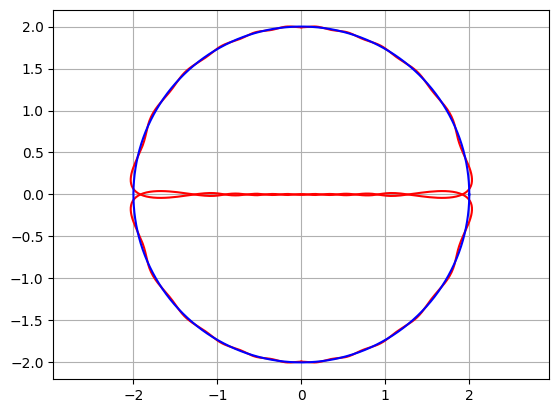

In [4]:
import matplotlib.pyplot as plt
x_core = core_series_values * np.sin(phi_values)
y_core = 1 + core_series_values * np.cos(phi_values)
y_core_lower = -y_core

x_ring = ring_series_values * np.cos(theta_values)
y_ring = ring_series_values * np.sin(theta_values)

plt.plot(x_core, y_core, c='r')
plt.plot(x_core, y_core_lower, c='r')
plt.plot(x_ring, y_ring, c='b')
plt.axis('equal')
plt.grid(True)

geometry = np.vstack((x_core, y_core, y_core_lower, x_ring, y_ring)).T


1. solve the Green's function using elliptical integrals

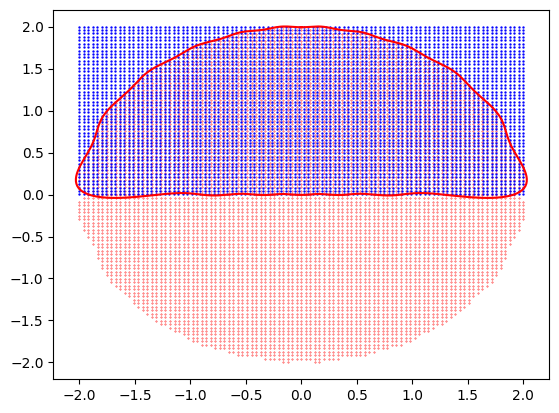

In [5]:
# x, y are the coordinates for computing stream function
x, y = np.linspace(-2, 2, 100), np.linspace(.001, 2, 50)
X, Y = np.meshgrid(x, y)


# x_int, y_int are the coordinates for integration (inside the core)
x_int, y_int = np.linspace(-2, 2, 99), np.linspace(0.001, 2, 49)
X_int, Y_int = np.meshgrid(x_int, y_int)
int_points = np.vstack([X_int.ravel(), Y_int.ravel()]).T
dx_int, dy_int = np.diff(x_int)[0], np.diff(y_int)[0]

# collect all the points inside the core, where vorticity is non-zero
# first, consider only the upper core (y > 0) to avoid invalid numerical values
upper_core = Path(np.vstack([x_core, y_core]).T).contains_points(int_points)
upper_points = int_points[upper_core]

mirror_points = np.copy(upper_points)
mirror_points[:, 1] = -mirror_points[:, 1]

inside_points = np.vstack([upper_points, mirror_points])

plt.scatter(inside_points[:, 0], inside_points[:, 1], c='r', s=0.1)
plt.scatter(X, Y, c='b', s=0.5)
plt.plot(x_core, y_core, c='r')


In [6]:
r_test = Y.flatten().astype(PRECISION)
x_test = X.flatten().astype(PRECISION)
r_p = np.abs(inside_points[:, 1]).astype(PRECISION)
x_p = inside_points[:, 0].astype(PRECISION)

R1_sq = (x_p - x_test[:, np.newaxis])**2 + (r_p - r_test[:, np.newaxis])**2
R2_sq = (x_p - x_test[:, np.newaxis])**2 + (r_p + r_test[:, np.newaxis])**2
kai_sq = 1 - R1_sq / R2_sq
kai = np.sqrt(kai_sq)

dG = np.sqrt(r_p * r_test[:, np.newaxis]) * ((2/kai-kai)*sp.special.ellipk(kai_sq).astype(PRECISION) - 2*sp.special.ellipe(kai_sq)/kai).astype(PRECISION) / (2 * np.pi)
# psi = np.sum(dG * r_p, axis=1) - 0.5 * W * (r_test **2)
# psi = np.sum(dG * r_p, axis=1) * dx_int * dy_int - 0.5 * 0.59 * (r_test **2)
psi = np.sum(dG * r_p * dx_int * np.ones_like(dG) * dy_int * np.ones_like(dG), axis=1) / (alpha**2) - W_norbury * (r_test **2)
psi = psi.reshape(X.shape)

x_psi = x.copy()
y_psi = np.hstack([-y[::-1], y])
X_psi, Y_psi = np.meshgrid(x_psi, y_psi)
mirror_psi = np.vstack([psi[::-1], psi])




**The following results are already normalised with $U_f=0.5$ and $L_f=R_0=1$.** \
If you want to non-dimensionalise with other scales $U_f^\prime$, need to modify the output files proportionally, \
by multiplying the output values a factor of $\frac{U_{f0}}{U_f^\prime}=\frac{1/2}{U_f^\prime}$

ammend the r=0 row with psi=0

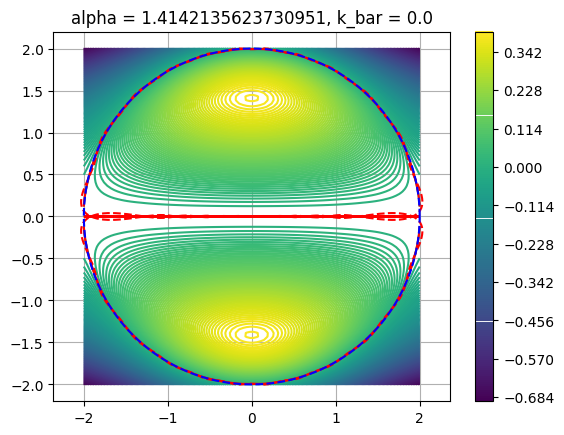

In [7]:
middle_row_idx = Y_psi.shape[0] // 2

# add r=0 in the grid
y_psi = np.insert(y_psi, middle_row_idx, 0)
X_psi, Y_psi = np.meshgrid(x_psi, y_psi)

# add psi=0 at r=0
mirror_psi = np.insert(mirror_psi, middle_row_idx, 0, axis=0)

cs = plt.contour(X_psi, Y_psi, mirror_psi, 200)
plt.contour(X_psi, Y_psi, mirror_psi, levels=[k/U_f], colors='r')
plt.plot(x_core, y_core, c='r',linestyle='dashed')
plt.plot(x_core, y_core_lower, c='r',linestyle='dashed')
plt.plot(x_ring, y_ring, 'b',linestyle='dashed')
plt.title(f'alpha = {alpha}, k_bar = {k/U_f}')
plt.axis('equal')
plt.colorbar(cs)
plt.grid(True)

In [8]:
center = np.unravel_index(np.argmax(mirror_psi), mirror_psi.shape)
X_psi[center], Y_psi[center]

(-0.02020202020202011, -1.4288571428571428)

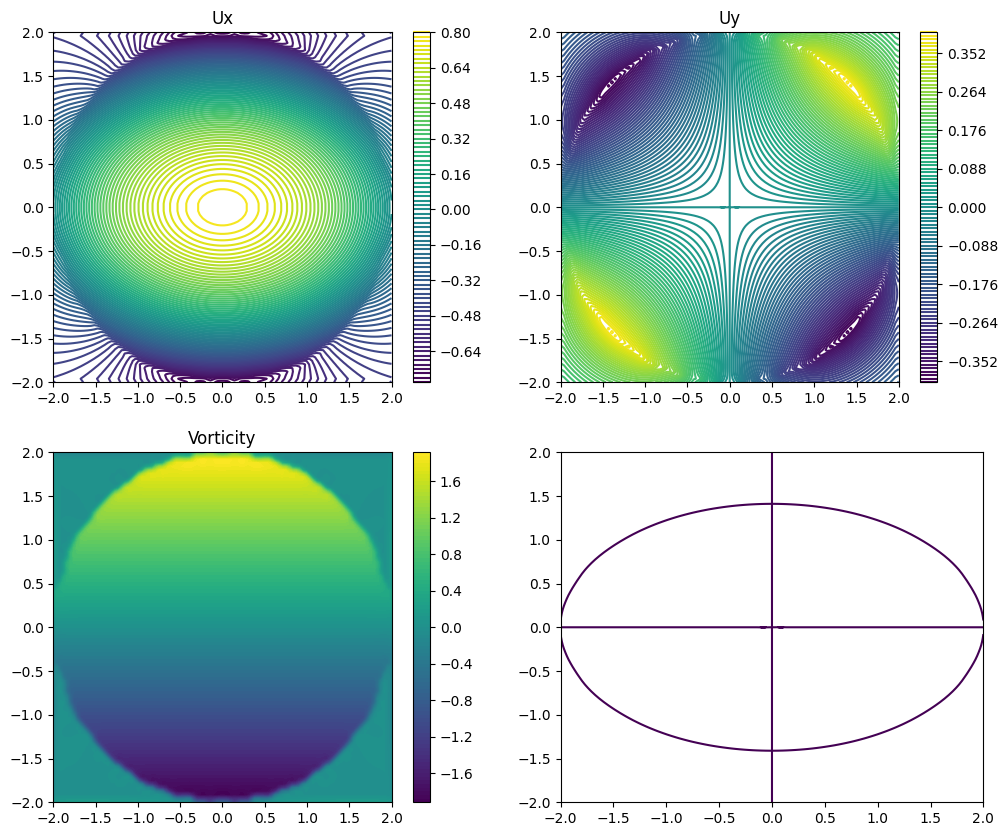

In [12]:
def velocity_field(x_upper, y_upper, psi_upper):

    # # only compute for the upper half, then mirror the result
    dx, dy = x_upper[1] - x_upper[0], y_upper[-1] - y_upper[-2]   
    psi_x = np.gradient(psi_upper, dx, axis=1)
    psi_y = np.gradient(psi_upper, dy, axis=0)
    Ux_upper = psi_y[1:] / y_upper[1:, np.newaxis]
    Ux_upper = np.vstack([Ux_upper[0], Ux_upper])
    Uy_upper =  - psi_x / y_upper[:, np.newaxis]

    # # mirror
    Ux = np.vstack([Ux_upper[::-1], Ux_upper])
    Ux = np.insert(Ux, middle_row_idx, Ux[middle_row_idx, :], axis=0)
    Uy = np.vstack([-Uy_upper[::-1], Uy_upper])
    Uy = np.insert(Uy, middle_row_idx, 0, axis=0)

    vorticity = np.gradient(Uy, dx, axis=1) - np.gradient(Ux, dy, axis=0)
    return Ux, Uy, vorticity

Ux, Uy, vorticity = velocity_field(x, y, psi)


# # Remove rows 39 and 40 from X_psi, Y_psi, and Ux
# X_psi_trimmed = np.delete(X_psi, [(len(x_psi) // 2 -1), (len(x_psi) // 2)], axis=0)
# Y_psi_trimmed = np.delete(Y_psi, [(len(x_psi) // 2 -1), (len(x_psi) // 2)], axis=0)
# Ux_trimmed = np.delete(Ux, [(len(x_psi) // 2 -1), (len(x_psi) // 2)], axis=0)


fig, ax = plt.subplots(2,2, figsize=(12, 10))
CS = ax[0,0].contour(X_psi, Y_psi, Ux, 100)
cbar = fig.colorbar(CS, ax=ax[0,0])
# ax[0,0].contour(X_psi, Y_psi, mirror_psi, 30, cmap='gray')
ax[0,0].set_title('Ux')

CS1 = ax[0,1].contour(X_psi, Y_psi, Uy, 100)
cbar1 = fig.colorbar(CS1, ax=ax[0,1])
# ax[0,1].contour(X_psi, Y_psi, mirror_psi, 30, cmap='gray')
ax[0,1].set_title('Uy')

CS2 = ax[1,0].contourf(X_psi, Y_psi, vorticity, 100)
cbar2 = fig.colorbar(CS2, ax=ax[1,0])
# ax[1,0].contour(X_psi, Y_psi, mirror_psi, 30, cmap='gray')
ax[1,0].set_title('Vorticity')

CS3 = ax[1,1].contour(X_psi, Y_psi, Ux, levels=[0])
CS4 = ax[1,1].contour(X_psi, Y_psi, Uy, levels=[0])


In [13]:
inside_vorticity = np.zeros_like(vorticity)
inside_vorticity = vorticity[middle_row_idx:, :]
integrated_vorticity = np.sum(inside_vorticity * dx_int * dy_int)
integrated_vorticity

5.478610409123975

In [14]:
import os

dUxdx = np.gradient(Ux, x_psi, axis=1)
dUxdy = np.gradient(Ux, y_psi, axis=0)
dUydx = np.gradient(Uy, x_psi, axis=1)
dUydy = np.gradient(Uy, y_psi, axis=0)

path = 'velocity_results/alpha1.4_2D_'

np.save(path + 'Ux.npy', Ux)
np.save(path + 'Uy.npy', Uy)
np.save(path + 'x.npy', x_psi)
np.save(path + 'y.npy', y_psi)
np.save(path + 'dUxdx.npy', dUxdx)
np.save(path + 'dUxdy.npy', dUxdy)
np.save(path + 'dUydx.npy', dUydx)
np.save(path + 'dUydy.npy', dUydy)
np.save(path + 'geometry.npy', geometry)



In [15]:
# create and save 2d interpolation functions
from scipy.interpolate import interp2d
import pickle

Ux_interp = interp2d(x_psi, y_psi, Ux)
Uy_interp = interp2d(x_psi, y_psi, Uy)
dUxdx_interp = interp2d(x_psi, y_psi, dUxdx)
dUxdy_interp = interp2d(x_psi, y_psi, dUxdy)
dUydx_interp = interp2d(x_psi, y_psi, dUydx)
dUydy_interp = interp2d(x_psi, y_psi, dUydy)

with open(path + 'interp_functions.pkl', 'wb') as f:
    pickle.dump((Ux_interp, Uy_interp, dUxdx_interp, dUxdy_interp, dUydx_interp, dUydy_interp), f)